In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
!pip install pmdarima

In [3]:
data =pd.read_csv(r"C:\Users\dora2\Desktop\경희대\쿠다\심화프로젝트\월마트 캐글\Walmart Data Analysis and Forcasting.csv", encoding='cp949')

In [4]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [5]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [6]:
missing_values = data.isnull().sum()

In [7]:
missing_values

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

# Feature Engineering
년월일 데이터를 쪼개서 새로운 열로 만드는 작업

In [8]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [9]:
#년월일 데이터를 쪼개서 새로운 열로 만들기
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [10]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DayOfWeek,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,4,9,2012
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,4,10,2012
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,4,10,2012
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,4,10,2012


# EDA
데이터 분석하기전에 가장 매출액높은 지점 계산해봄

In [11]:
#Ranking stores in descending order of weekly sales totals
data[['Store','Weekly_Sales']].groupby(['Store'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False)#.plot.bar()

,Weekly_Sales
Store,
20,2.107677e+06
4,2.094713e+06
14,2.020978e+06
13,2.003620e+06
2,1.925751e+06
10,1.899425e+06
27,1.775216e+06
6,1.564728e+06
1,1.555264e+06


일주일동안의 매출액의 평균을 계산하고 그 평균이 가장 높은 지점 순위임. 

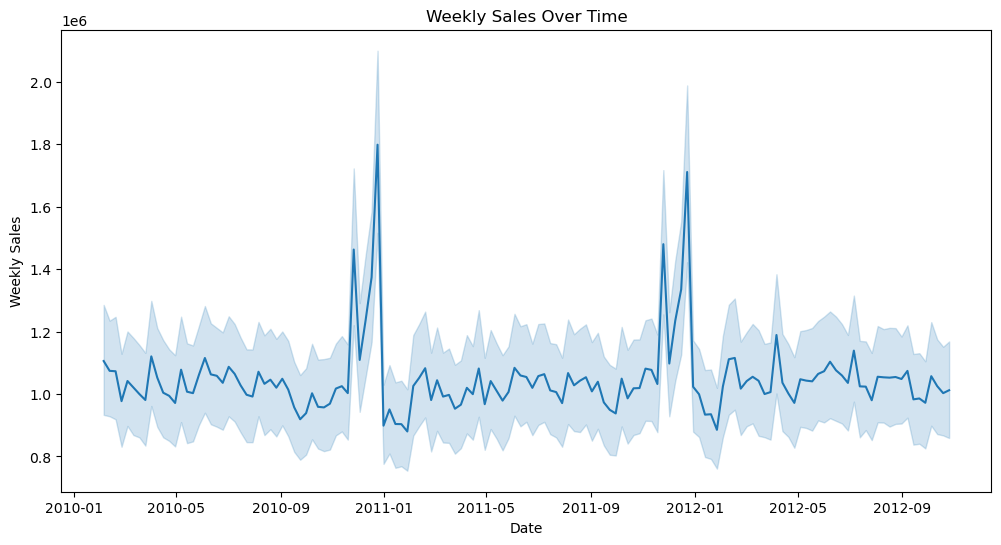

In [12]:
# Visualize the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=data)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

연말에 특히 판매액이 높은걸 알수있음. 

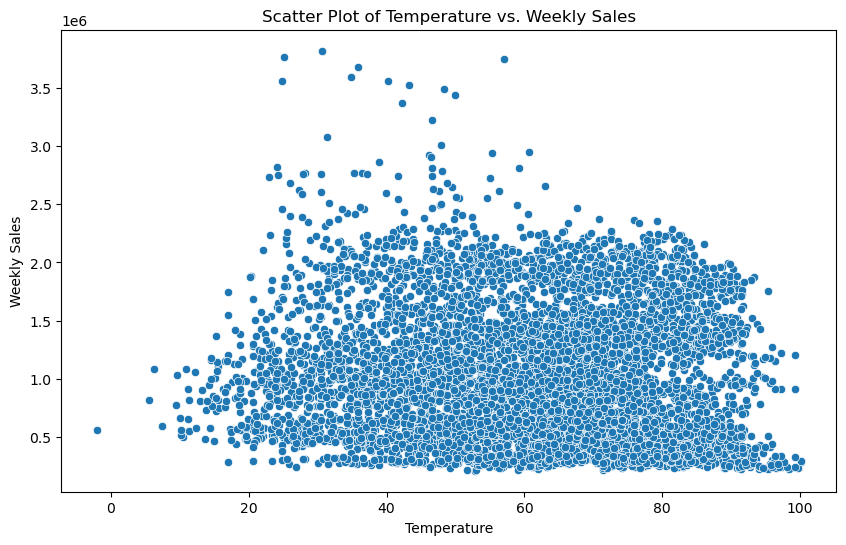

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
plt.title('Scatter Plot of Temperature vs. Weekly Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

판매액과 기온은 그렇게 상관이없는걸 알수 있음. 

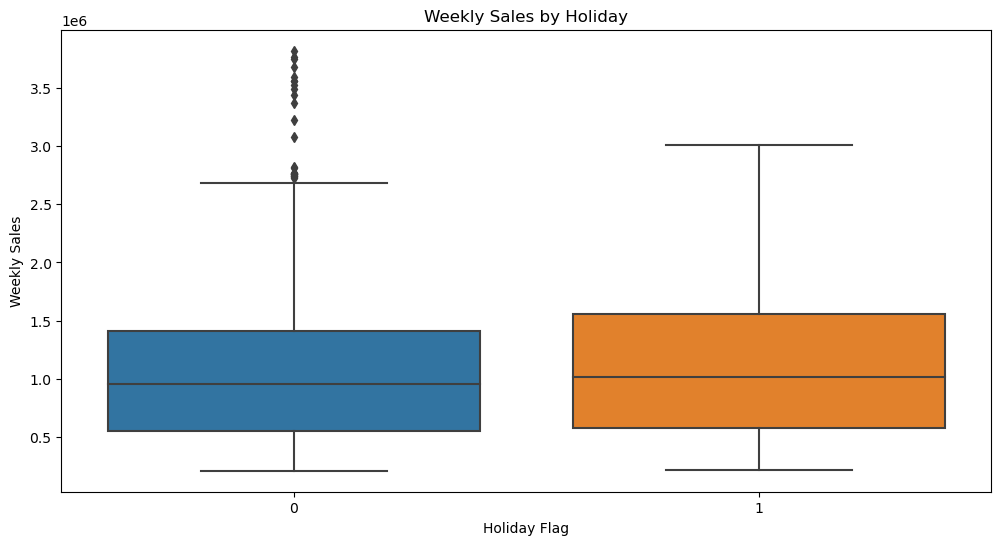

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.show()

휴일이 있는 주에 매출이 조금더 높더라. 휴일이 없는주에 비해서는 

<Axes: xlabel='Month'>

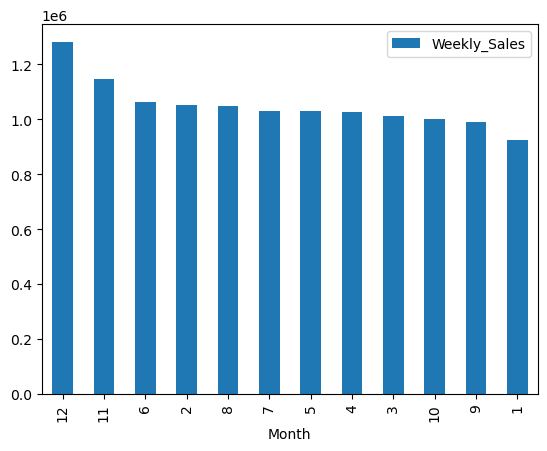

In [15]:
data[['Month','Weekly_Sales']].groupby(['Month'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False).plot.bar()

12월달에 가장 판매액이 많구만

In [16]:
data[['Year','Weekly_Sales']].groupby(['Year'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False)#.plot.bar()

,Weekly_Sales
Year,
2010,1.059670e+06
2011,1.046239e+06
2012,1.033660e+06


In [17]:
data[['Year','CPI']].groupby(['Year'],as_index=True).mean().sort_values(by='CPI',ascending=False)

,CPI
Year,
2012,175.498781
2011,171.545716
2010,168.101782


뭐 당연하게 소비자 물가지수가 올라가는 시기에 매출액이 감소했음을 알수있다. 

In [18]:
# Correlation analysis
correlation_matrix = data.corr()

C:\Users\dora2\AppData\Local\Temp\ipykernel_7508\412282125.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


C:\Users\dora2\AppData\Local\Temp\ipykernel_7508\1109744947.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


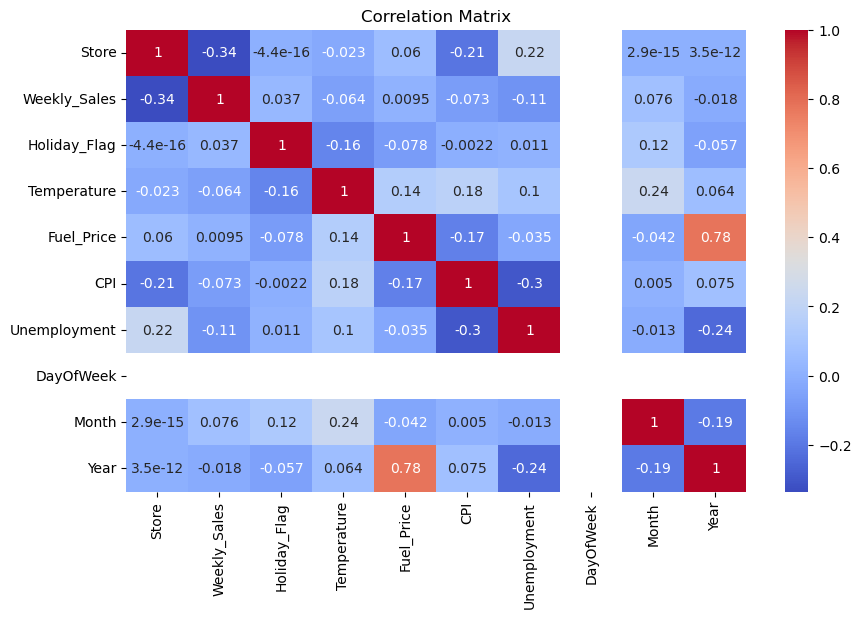

In [19]:
# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

음...근데 뭐 상관관계가 있다고 할만한 인수들은 없다. 

# Time-Series Analysis

In [42]:
#visualize the underlying components of the time series, including trend, seasonality, and residual.
decomposition = seasonal_decompose(data['Weekly_Sales'], period=7)
trend = decomposition.trend #추세
seasonal = decomposition.seasonal#계절성
residual = decomposition.resid #잔차

원래 시계열 자료에서 추세, 계절성, 잔차라는 데이터를 시계열 분해할수있음. 

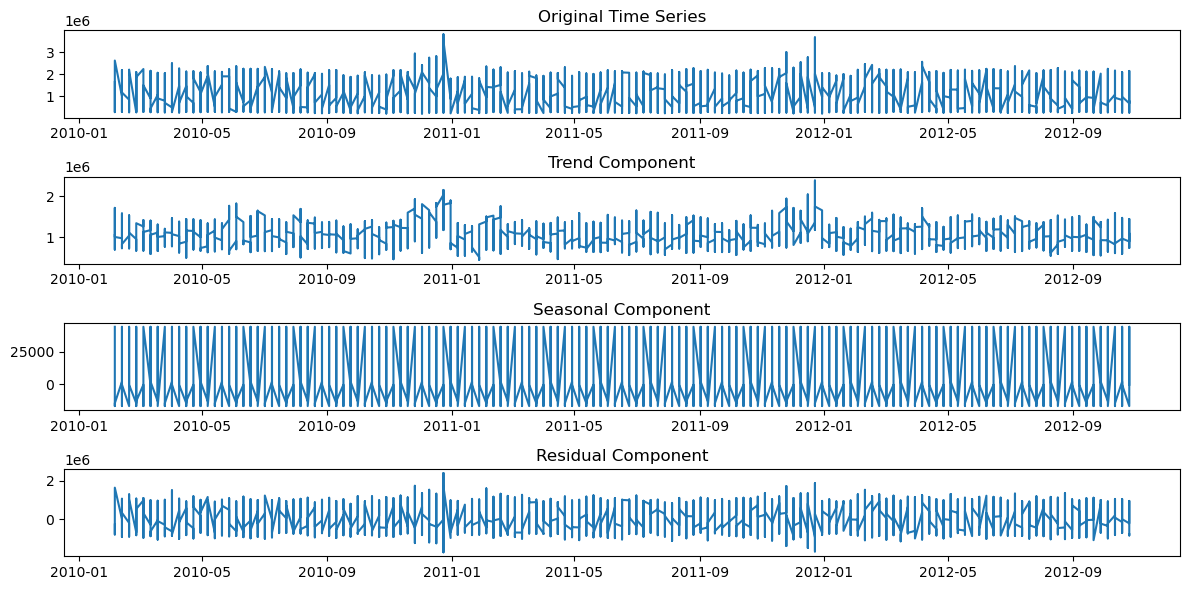

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(data['Date'], data['Weekly_Sales'], label='Original')
plt.title('Original Time Series')
plt.subplot(412)
plt.plot(data['Date'], trend, label='Trend')
plt.title('Trend Component')
plt.subplot(413)
plt.plot(data['Date'], seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.subplot(414)
plt.plot(data['Date'], residual, label='Residual')
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Machine Learning Modeling

In [21]:
# Split the data into features and target variable
X = data[['Store', 'Holiday_Flag', 'CPI', 'DayOfWeek', 'Month', 'Year']]
y = data['Weekly_Sales']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [23]:
# Create a Linear Regression model
linear_model = LinearRegression()

In [24]:
# Fit the model to the training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [25]:
# Get the coefficients of the Linear Regression model
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print('Linear Regression Coefficients:')
print(coefficients)

Linear Regression Coefficients:
        Feature   Coefficient
1  Holiday_Flag  6.378827e+04
4         Month  1.367282e+04
5          Year  4.234399e+03
3     DayOfWeek -2.182787e-11
2           CPI -2.086117e+03
0         Store -1.571423e+04


In [26]:
# Predict sales on the test set 예측값 계산해보기
y_pred_linear = linear_model.predict(X_test)

In [27]:
# Calculate evaluation metrics for Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression Mean Squared Error (MSE)평균제곱오차: {mse_linear}')
print(f'Linear Regression Mean Absolute Error (MAE)평균 절대 오차: {mae_linear}')
print(f'Linear Regression R-squared (R2)결정계수 R제곱: {r2_linear}')

Linear Regression Mean Squared Error (MSE)평균제곱오차: 274358062063.70123
Linear Regression Mean Absolute Error (MAE)평균 절대 오차: 434468.7630628272
Linear Regression R-squared (R2)결정계수 R제곱: 0.14836512598967277


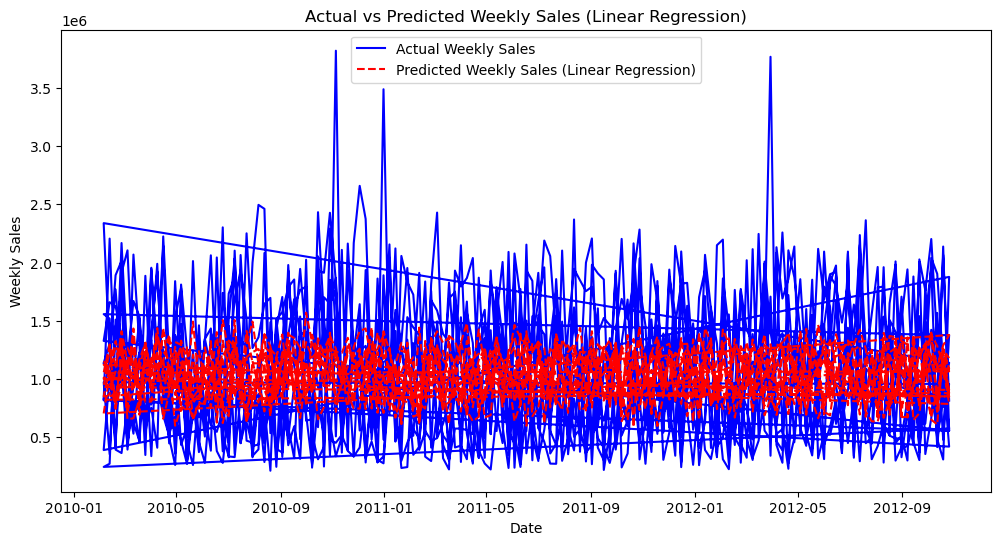

In [28]:
# 선형 회귀 모델을 사용하여 예측한 주간 판매량과 실제 주간 판매량을 비교하는 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual Weekly Sales', color='blue')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred_linear, label='Predicted Weekly Sales (Linear Regression)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales (Linear Regression)')
plt.legend()
plt.show()

# Random Forest Regressor

In [29]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [30]:
# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# Predict sales on the test set
y_pred_rf = rf_model.predict(X_test)

In [32]:
# Calculate evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error (MSE): {mse_rf}')
print(f'Random Forest Mean Absolute Error (MAE): {mae_rf}')
print(f'Random Forest R-squared (R2): {r2_rf}')

Random Forest Mean Squared Error (MSE): 18565147603.976215
Random Forest Mean Absolute Error (MAE): 70494.92054607614
Random Forest R-squared (R2): 0.9423719244050338


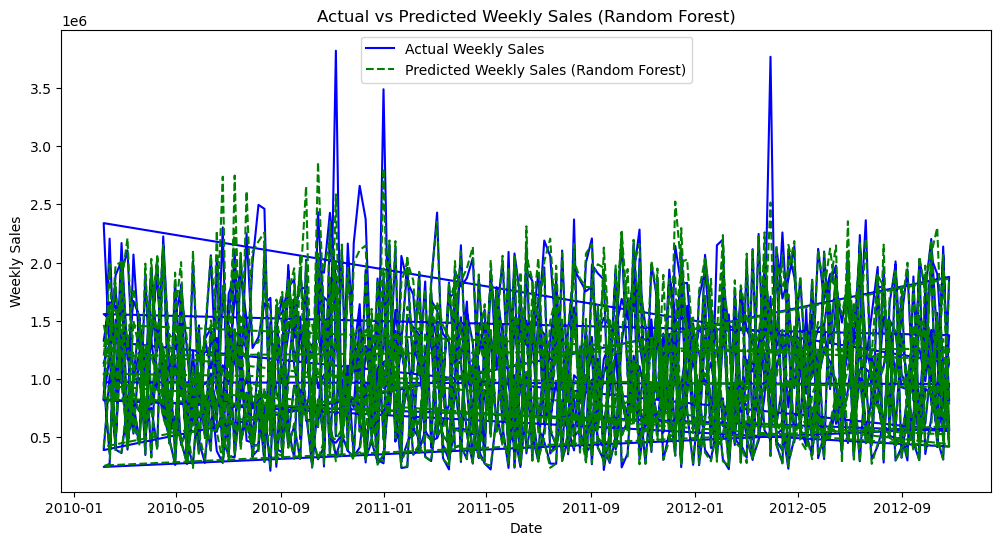

In [33]:
# Plot actual vs predicted sales for Random Forest
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual Weekly Sales', color='blue')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred_rf, label='Predicted Weekly Sales (Random Forest)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales (Random Forest)')
plt.legend()
plt.show()

오 랜덤포레스트가 예측한게 선형회귀보다 낫다

In [34]:
# Get feature importances for Random Forest
rf_feature_importance = rf_model.feature_importances_

# Pair feature names with their importance scores
feature_names = X.columns
rf_feature_importance_dict = dict(zip(feature_names, rf_feature_importance))

# Sort features by importance in descending order
rf_sorted_feature_importance = sorted(rf_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print('Random Forest Feature Importance:')
for feature, importance in rf_sorted_feature_importance:
    print(f'{feature}: {importance}')

Random Forest Feature Importance:
Store: 0.764231221832417
CPI: 0.18648012826680344
Month: 0.037763010795528025
Holiday_Flag: 0.006533810476728712
Year: 0.004991828628522889
DayOfWeek: 0.0


# Time Series Forecasting - SARIMA

In [35]:
# Sort the data by date for time series analysis
data.sort_values('Date', inplace=True)

In [36]:
# Create a SARIMA model for weekly sales forecasting
sarima_model = SARIMAX(data['Weekly_Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

C:\Users\dora2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dora2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
# Calculate SARIMA predictions on the training data
y_pred_sarima_training = sarima_results.predict(start=0, end=len(X_train) - 1)

In [38]:
# Calculate MSE and MAE for SARIMA on the training data
mse_sarima_training = mean_squared_error(y_train, y_pred_sarima_training)
mae_sarima_training = mean_absolute_error(y_train, y_pred_sarima_training)

# Print SARIMA training accuracy metrics
print(f'SARIMA Mean Squared Error (MSE) on Training Data: {mse_sarima_training}')
print(f'SARIMA Mean Absolute Error (MAE) on Training Data: {mae_sarima_training}')

SARIMA Mean Squared Error (MSE) on Training Data: 333449066850.99274
SARIMA Mean Absolute Error (MAE) on Training Data: 476756.0326933429


In [39]:
# Forecast future sales using SARIMA
future_sales_sarima = sarima_results.forecast(steps=len(X_test))
future_data = X_test.copy()
future_data['Predicted_Weekly_Sales_SARIMA'] = future_sales_sarima

C:\Users\dora2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [40]:
# Calculate evaluation metrics for SARIMA on the test data
mse_sarima = mean_squared_error(y_test, future_sales_sarima)
mae_sarima = mean_absolute_error(y_test, future_sales_sarima)
r2_sarima = r2_score(y_test, future_sales_sarima)
print(f'SARIMA Mean Squared Error (MSE) on Test Data: {mse_sarima}')
print(f'SARIMA Mean Absolute Error (MAE) on Test Data: {mae_sarima}')
print(f'SARIMA R-squared (R2) on Test Data: {r2_sarima}')

SARIMA Mean Squared Error (MSE) on Test Data: 326103891792.6171
SARIMA Mean Absolute Error (MAE) on Test Data: 472425.0106246186
SARIMA R-squared (R2) on Test Data: -0.0122591066290616


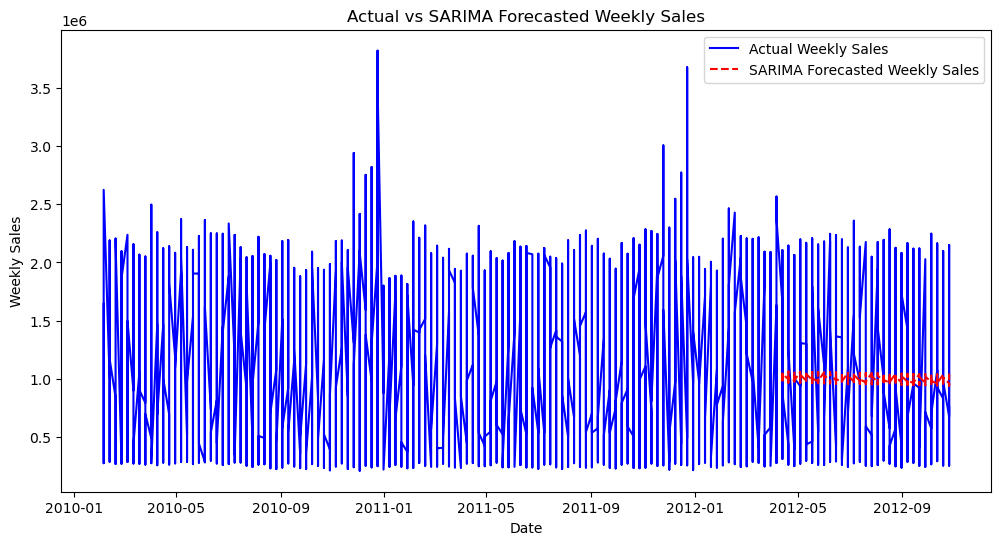

In [41]:
# Plot actual vs predicted sales for SARIMA
plt.figure(figsize=(12, 6))
# Plot actual sales for the historical data
plt.plot(data['Date'], data['Weekly_Sales'], label='Actual Weekly Sales', color='blue')
# Plot SARIMA forecast for the future data
plt.plot(data['Date'].iloc[-len(X_test):], future_sales_sarima, label='SARIMA Forecasted Weekly Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs SARIMA Forecasted Weekly Sales')
plt.legend()
plt.show()

# Comparing all 3 models

이부분은 우리랑 상관없을거같긴한데 ..우선 하긴했음.

In [45]:
# Compare model accuracies
print(f'Linear Regression Mean Squared Error (MSE): {mse_linear}')
print(f'Random Forest Mean Squared Error (MSE): {mse_rf}')
print(f'SARIMA Mean Squared Error (MSE): {mse_sarima}')

Linear Regression Mean Squared Error (MSE): 274358062063.70123
Random Forest Mean Squared Error (MSE): 18565147603.976215
SARIMA Mean Squared Error (MSE): 326103891792.6171


결과를 정리하자면 SARIMA가 제일 결과가 좋지않았고 Random Forest모델이 가장 좋은 결과를 얻을수 있었다고함. 